# Cal-CRAI Index: Society & Economy Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Outlier handling
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'society_economy_'  # will be used for naming newly created columns
csv_file_prefix = 'society' # for society & economy domain specifically, all files in this domain are named just society

input_folder = r'C:/Users/jespi/eagle/carb-climate-index-19/aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-19/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
merged_output_file = 'concatenate_society_economy_metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(csv_file_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within society domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_society_economy_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_population_ambulatory_disabilities',
  'percent_total_pop_american_indian_alaska_native',
  'percent_population_cognitive_disabilities',
  'est_gini_index',
  'hachman_index',
  'percent_children_household_financial_assistance',
  'percent_1miurban_10mirural',
  'avg_hpsscore_mental_shortage_metric',
  'real_percent_total_pop_over_65',
  'avg_hpsscore_primary_care_metric',
  'percent_total_pop_under_5',
  'asthma_related_ed_visits_per_10000_people_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'education_percent_2019',
  'avg_percent_population_homeless',
  'housing_burden_percent_2019',
  'sum_imp_water_bodies',
  'linguistic_isolation_percent_2019',
  'low_birth_weight_percent_2019',
  'Percent of households without air conditioning',
  'Percent of population employed and aged > 16 working outdoors',
  'poverty_percent_2019',
  'unemployment_percent_2019',
  'Number of Violent Crimes per 10,000 Population',
  'percent_population_

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_society_df = pd.read_csv('concatenate_society_economy_metrics.csv')
processed_society_df

,GEOID,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236,15.885023,58.256725,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500,0.000000,30.832177,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000,3.184713,30.832177,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836,14.240170,30.832177,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078,4.435484,30.832177,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265,13.194444,0.000000,...,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018,44.331984,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


### 1b) Handle outliers for each column / metric:
We set a max and min fence based based on each metrics 90th and 10th percentiles with the `handle_outliers` function
* Max fence = 3 x 90th percentile
* Min fence = -3 x 10th percentile

Note: Fencing/outlier handling is not conducted for demographic based metrics (all metrics within vulnerable indicator within Society and Economy domain)

In [6]:
# handle outliers
no_outlier_society_economy_metrics = handle_outliers(processed_society_df, domain_prefix, summary_stats=True)

For column blood and organ banks per 10000 people:
  Q1 (10th percentile): 0.0271720260972215
  Q3 (90th percentile): 0.0661606844543342
  IQR: 0.03898865835711271
  Max fence: 0.19848205336300262
  Min fence: -0.0815160782916645
For column est_gini_index:
  Q1 (10th percentile): 0.3445
  Q3 (90th percentile): 0.5091
  IQR: 0.16460000000000002
  Max fence: 1.5272999999999999
  Min fence: -1.0334999999999999
For column hachman_index:
  Q1 (10th percentile): 0.7127263993671944
  Q3 (90th percentile): 0.9503871439131188
  IQR: 0.23766074454592445
  Max fence: 2.8511614317393565
  Min fence: -2.138179198101583
For column est_median_income_dollars:
  Q1 (10th percentile): 49914.6
  Q3 (90th percentile): 158417.2
  IQR: 108502.6
  Max fence: 475251.60000000003
  Min fence: -149743.8
For column health and personal care stores per 10000 people:
  Q1 (10th percentile): 1.8406258816081909
  Q3 (90th percentile): 3.327063639904233
  IQR: 1.4864377582960422
  Max fence: 9.981190919712699
  Min fen

In [7]:
no_outlier_society_economy_metrics

,GEOID,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,4.680330,0.0,0.042072,5.170005,0.4228,0.926769,234236.0,15.885023,58.256725,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,4.005589,0.4,0.042072,1.904253,0.4084,0.926769,225500.0,0.000000,30.832177,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,2.295782,0.5,0.042072,3.529687,0.4615,0.926769,164000.0,3.184713,30.832177,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,3.646564,0.5,0.042072,3.165358,0.5063,0.926769,158836.0,14.240170,30.832177,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,3.367941,0.1,0.042072,6.219631,0.4571,0.926769,95078.0,4.435484,30.832177,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.535332,0.2,NaN,0.544662,0.4252,0.784133,54265.0,13.194444,0.000000,...,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,8.387800,0.3,NaN,3.745976,0.5024,0.784133,67321.0,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,9.160082,2.6,NaN,9.702797,0.4875,0.784133,102534.0,0.000000,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,16.826923,1.1,NaN,9.405941,0.4072,0.784133,37018.0,44.331984,37.636696,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


### 1c) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [8]:
# standardizing our df
columns_to_process = [col for col in no_outlier_society_economy_metrics.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(no_outlier_society_economy_metrics, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [9]:
# this will show the standardized columns as well as their max and min column counterparts used in the process

#min_max_metrics

Isolate for GEOID and standardized columns exclusively

In [10]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]

In [11]:
min_max_standardized_society_economy_metrics_df.head()

,GEOID,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,...,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.046803,0.000000,0.13134,0.000876,0.503770,0.962333,0.936422,0.158850,0.582567,...,0.134367,0.054054,0.012,0.280817,0.643066,0.012265,0.103753,0.109878,0.797158,0.004818
1,6001400200,0.040056,0.005464,0.13134,0.000323,0.483284,0.962333,0.900035,0.000000,0.308322,...,0.041344,0.000000,0.000,0.295405,0.643066,0.021277,0.105960,0.068337,0.797158,0.014672
2,6001400300,0.022958,0.006831,0.13134,0.000598,0.558828,0.962333,0.643873,0.031847,0.308322,...,0.104651,0.000000,0.080,0.275711,0.643066,0.015369,0.102649,0.088838,0.797158,0.028964
3,6001400400,0.036466,0.006831,0.13134,0.000537,0.622564,0.962333,0.622364,0.142402,0.308322,...,0.180879,0.000000,0.009,0.323851,0.643066,0.028617,0.221854,0.056948,0.797158,0.039271
4,6001400500,0.033679,0.001366,0.13134,0.001054,0.552568,0.962333,0.356797,0.044355,0.308322,...,0.180879,0.000000,0.017,0.265500,0.643066,0.050283,0.230684,0.086560,0.797158,0.078438


### 1d) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

Some metrics indicate a communities resistance rather than vulnerablity. For example, number of emergency personel per 10,000 people represents a communities ability to respond to emergencies. For this metric, the higher the number, the more resilient. So we identify these 'resilient' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate vulnerability

In [12]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_population_ambulatory_disabilities',
  'percent_total_pop_american_indian_alaska_native',
  'percent_population_cognitive_disabilities',
  'est_gini_index',
  'hachman_index',
  'percent_children_household_financial_assistance',
  'percent_1miurban_10mirural',
  'avg_hpsscore_mental_shortage_metric',
  'real_percent_total_pop_over_65',
  'avg_hpsscore_primary_care_metric',
  'percent_total_pop_under_5',
  'asthma_related_ed_visits_per_10000_people_2019',
  'cardiovascular_disease_related_ed_visits_per_10000_people_2019',
  'education_percent_2019',
  'avg_percent_population_homeless',
  'housing_burden_percent_2019',
  'sum_imp_water_bodies',
  'linguistic_isolation_percent_2019',
  'low_birth_weight_percent_2019',
  'Percent of households without air conditioning',
  'Percent of population employed and aged > 16 working outdoors',
  'poverty_percent_2019',
  'unemployment_percent_2019',
  'Number of Violent Crimes per 10,000 Population',
  'percent_population_

In [13]:
# Access the resilient column names from the dictionary
resilient_columns = metric_vulnerable_resilient_dict['resilient']

# Identify columns in the DataFrame that contain any of the resilient column names as substrings
resilient_columns_in_df = [col for col in min_max_standardized_society_economy_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in resilient_columns)]

# Create a new DataFrame with the adjusted resilient columns
adjusted_resilient_df = min_max_standardized_society_economy_metrics_df.copy()

# Subtract the standardized resilient columns from one and store the result in the new DataFrame
adjusted_resilient_df.loc[:, resilient_columns_in_df] = (
    1 - adjusted_resilient_df.loc[:, resilient_columns_in_df]
)

In [14]:
adjusted_resilient_df

,GEOID,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,blood and organ banks per 10000 people_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,est_gini_index_min_max_standardized,hachman_index_min_max_standardized,est_median_income_dollars_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,...,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 10,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6001400100,0.046803,0.000000,0.86866,0.000876,0.503770,0.962333,0.063578,0.158850,0.582567,...,0.134367,0.054054,0.012000,0.280817,0.643066,0.012265,0.103753,0.109878,0.797158,0.004818
1,6001400200,0.040056,0.005464,0.86866,0.000323,0.483284,0.962333,0.099965,0.000000,0.308322,...,0.041344,0.000000,0.000000,0.295405,0.643066,0.021277,0.105960,0.068337,0.797158,0.014672
2,6001400300,0.022958,0.006831,0.86866,0.000598,0.558828,0.962333,0.356127,0.031847,0.308322,...,0.104651,0.000000,0.080000,0.275711,0.643066,0.015369,0.102649,0.088838,0.797158,0.028964
3,6001400400,0.036466,0.006831,0.86866,0.000537,0.622564,0.962333,0.377636,0.142402,0.308322,...,0.180879,0.000000,0.009000,0.323851,0.643066,0.028617,0.221854,0.056948,0.797158,0.039271
4,6001400500,0.033679,0.001366,0.86866,0.001054,0.552568,0.962333,0.643203,0.044355,0.308322,...,0.180879,0.000000,0.017000,0.265500,0.643066,0.050283,0.230684,0.086560,0.797158,0.078438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.005353,0.002732,NaN,0.000092,0.507185,0.776821,0.813198,0.131944,0.000000,...,0.444444,0.000000,0.059167,0.315828,0.017253,0.080654,0.301325,0.077449,0.430398,0.025294
9125,6115041001,0.083878,0.004098,NaN,0.000635,0.617015,0.776821,0.758817,0.000000,0.376367,...,0.244473,0.081081,0.059167,0.354729,0.017253,0.158451,0.519990,0.213870,0.430398,0.048611
9126,6115041002,0.091601,0.035519,NaN,0.001645,0.595817,0.776821,0.612147,0.000000,0.376367,...,0.244473,0.081081,0.059167,0.354729,0.017253,0.158451,0.519990,0.213870,0.430398,0.271437
9127,6115041101,0.168269,0.015027,NaN,0.001594,0.481576,0.776821,0.885036,0.443320,0.376367,...,0.244473,0.081081,0.059167,0.354729,0.017253,0.158451,0.519990,0.213870,0.430398,0.130026


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [15]:
averaged_indicators_society_economy = compute_averaged_indicators(
    adjusted_resilient_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_society_economy

,GEOID,vulnerable_populations,social_services,economic_health
0,6001400100,0.166465,0.782271,0.509894
1,6001400200,0.142824,0.782271,0.515194
2,6001400300,0.138695,0.782271,0.625763
3,6001400400,0.160363,0.782271,0.654178
4,6001400500,0.151013,0.782271,0.719368
...,...,...,...,...
9124,6115040902,0.122242,0.646085,0.699068
9125,6115041001,0.192893,0.646085,0.717551
9126,6115041002,0.195635,0.646085,0.661595
9127,6115041101,0.209901,0.646085,0.714478


Sum all the non-census tract columns together to calculate the domain score

In [16]:
columns_to_sum = [col for col in averaged_indicators_society_economy.columns if col != 'GEOID']
summed_indicators_society_economy = compute_summed_indicators(
    df=averaged_indicators_society_economy, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.093194826054311


### 2a) Min-max standardize the summed columns

In [17]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [18]:
min_max_domain

,GEOID,summed_indicators_society_economy_domain_min,summed_indicators_society_economy_domain_max,summed_indicators_society_economy_domain_min_max_standardized
0,6001400100,0.0,2.093195,0.696843
1,6001400200,0.0,2.093195,0.688081
2,6001400300,0.0,2.093195,0.738932
3,6001400400,0.0,2.093195,0.762858
4,6001400500,0.0,2.093195,0.789536
...,...,...,...,...
9124,6115040902,0.0,2.093195,0.701031
9125,6115041001,0.0,2.093195,0.743614
9126,6115041002,0.0,2.093195,0.718192
9127,6115041101,0.0,2.093195,0.750271


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [19]:
min_max_standardized_society_economy_domain = min_max_domain[['GEOID', 'summed_indicators_society_economy_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [20]:
gdf = add_census_tracts(min_max_standardized_society_economy_domain)

Let's look at some summary statistics for this domain:

In [21]:
domain_summary_stats(gdf, 'summed_indicators_society_economy_domain_min_max_standardized')

Median summed_indicators_society_economy_domain_min_max_standardized domain value: 0.7676815980409805
Mean summed_indicators_society_economy_domain_min_max_standardized domain value: 0.763338309868222


In [22]:
gdf.columns

Index(['GEOID',
       'summed_indicators_society_economy_domain_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [23]:
domain_prefix

'society_economy_'

Now let's visualize the entire domain!

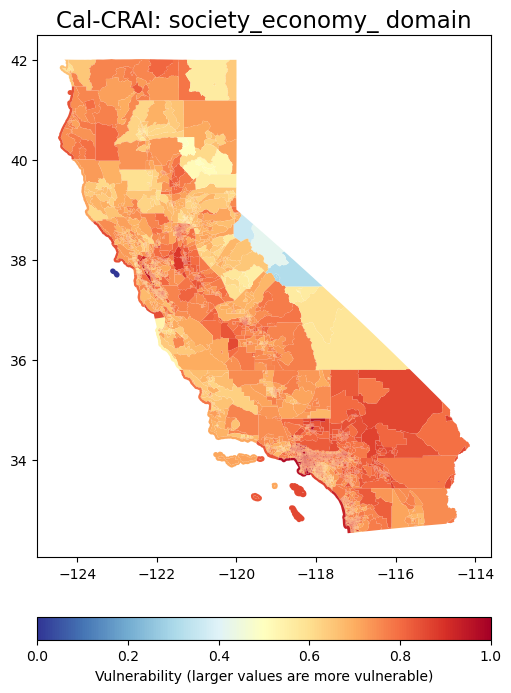

In [24]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

In [29]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import box

def plot_region_domain(gdf, counties_to_plot=None, region=None, plot_all=False, savefig=False, font_color='black', domain='society_economy_', domain_label_map=None):
    """
    Plots a domain score vulnerability for selected counties or regions, with the option to exclude features within a bounding box.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.
    
    counties_to_plot : list of str, optional
        A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
        Example: ['037', '071', '065', '029', '111'].
    
    region : str, optional
        A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
        If specified, this will override `counties_to_plot`.
    
    plot_all : bool, optional
        If True, plots all counties in California. Overrides `counties_to_plot` and `region`.
    
    savefig : bool, optional
        If True, the plot will be saved as a PNG file. Default is False.

    font_color : str, optional
        Color of the font for county labels. Default is 'black'.

    domain : str, optional
        The domain name used for labeling and column names. Default is 'society_economy_'.

    domain_label_map : dict, optional
        A dictionary to map the domain variable to a more readable label. Example: {'society_economy_': 'Society and Economy Domain'}
    
    Returns:
    --------
    None
        Displays the plot. Optionally saves the plot as a PNG file.
    """
    
    # If a domain label map is provided, use it to get a readable title. Otherwise, create it from the domain string.
    if domain_label_map:
        domain_name = domain_label_map.get(domain, domain.replace('_', ' ').title())
    else:
        domain_name = domain.replace('_', ' ').title()

    # Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'
    }

    # Define the new regional groups of counties
    regions = {
        'bay_area': ['001', '013', '041', '055', '081', '085', '087', '075', '095', '097'],
        'central_region': ['019', '029', '031', '039', '043', '047', '053', '069', '079', '099', '107', '109'],
        'inland_deserts': ['025', '027', '051', '065', '071'],
        'north_central': ['067', '077', '017', '033', '057', '061', '091', '101', '063', '113', '115'],
        'northern': ['015', '023', '035', '045', '049', '093', '089', '103', '105'],
        'south_coast': ['037', '059', '073', '083', '111']
    }

    # Set counties_to_plot based on the specified region or plot_all flag
    if plot_all:
        counties_to_plot = list(county_labels.keys())
        title = f'Vulnerability Index of All Counties in California - {domain_name}'
    elif region:
        counties_to_plot = regions.get(region, [])
        region_name = region.replace('_', ' ').title()  # Capitalize the region name for display
        title = f'Vulnerability Index of California\'s {region_name} - {domain_name}'
    else:
        title = f'Vulnerability Index of Selected Counties \n {domain_name}'

    # Load the census tract data
    census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
    ca_boundaries = gpd.read_file(census_shp_dir)
    ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)
    
    # Merge the passed GeoDataFrame with the census boundary data
    df2 = gdf.merge(ca_boundaries, on='GEOID')

    # Filter rows where COUNTYFP is in the `counties_to_plot` list
    df2_filtered = df2[df2['COUNTYFP'].isin(counties_to_plot)]

    # Convert to GeoDataFrame with the correct CRS if necessary
    df2_filtered = gpd.GeoDataFrame(df2_filtered, geometry='geometry', crs=4269)

    # Define the bounding box to exclude (xmin, ymin, xmax, ymax)
    exclusion_box = box(-122.8, 37.6, -123.2, 37.85) 
    
    # Exclude features within the bounding box
    df2_filtered = df2_filtered[~df2_filtered.intersects(exclusion_box)]

    # Check for invalid geometries
    invalid_geometries = df2_filtered[~df2_filtered['geometry'].is_valid]
    print("Number of invalid geometries:", len(invalid_geometries))

    # Group by COUNTYFP and take the geometry of the first row in each group
    county_boundaries = df2_filtered.dissolve(by='COUNTYFP')['geometry']

    # Check if there are any valid geometries left after filtering
    if len(county_boundaries) == 0:
        print('No valid geometries. Cannot plot.')
        return

    # Adjust figure size and padding based on the type and number of counties/regions
    if plot_all:
        fig_size = (8, 18)
        base_font_size = 5
    elif region:
        fig_size = (8, 14)
        base_font_size = 8
    else:
        # Specific counties
        num_counties = len(counties_to_plot)
        if num_counties == 1:
            fig_size = (6, 6)
            base_font_size = 12
        else:
            fig_size = (6 + (num_counties - 1) // 2, 10 + ((num_counties - 1) // 2) * 2)
            base_font_size = min(10, 6 + (num_counties / 10))

    fig, ax = plt.subplots(1, 1, figsize=fig_size, layout='compressed')

    # Plot county boundaries
    county_boundaries.boundary.plot(ax=ax, linewidth=0.55, edgecolor='black')

    # Plot the data
    df2_filtered.plot(column=f'summed_indicators_{domain}domain_min_max_standardized', 
                      ax=ax, 
                      vmin=0, vmax=1, 
                      legend=True, 
                      cmap='RdYlBu_r', 
                      legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 0.9})

    # Suppress specific UserWarning messages
    warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS. Results from 'area' are likely incorrect.")
    
    # Find the min and max county area to scale the font sizes accordingly
    min_area = county_boundaries.area.min()
    max_area = county_boundaries.area.max()

    # Adjust font size based on figure size and county area
    for county_code in counties_to_plot:
        label = county_labels.get(county_code, '')
        if label:  # Only add label if it exists in the dictionary
            # Get the centroid of the county
            centroid = county_boundaries[county_code].centroid

            # Dynamically adjust font size based on the area of the county
            county_area = county_boundaries[county_code].area

            # Normalize the area to a font size
            if max_area > min_area:
                font_size = base_font_size + (10 - base_font_size) * (county_area - min_area) / (max_area - min_area)
            else:
                font_size = base_font_size

            # Add text label to the plot with specified font color
            ax.text(centroid.x, centroid.y, label, weight='medium', fontsize=font_size, color=font_color, ha='center', va='baseline', alpha=1)

    # Set the plot title
    ax.set_title(title, fontsize=13, weight='normal')

    # Automatically adjust padding to be below x-axis ticks
    x_ticks = ax.get_xticks()
    x_tick_labels = ax.get_xticklabels()
    max_label_height = max([tick.get_window_extent().height for tick in x_tick_labels])

    # Adjust padding based on the maximum label height
    padding = max_label_height / fig.dpi

    # Optionally save the figure
    if savefig:
        plt.savefig(f'region_plot_{counties_to_plot}.png', dpi=300)

    # Display the plot
    plt.show()

Number of invalid geometries: 0


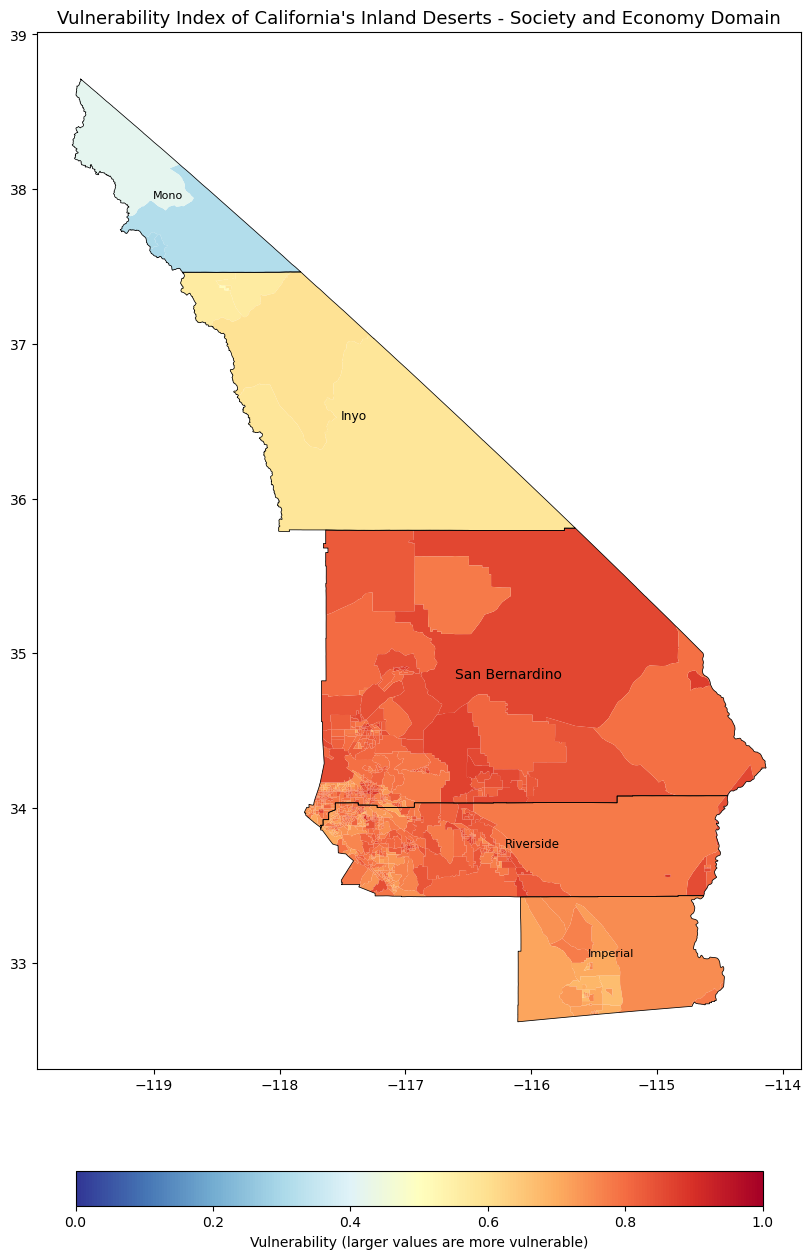

In [30]:
plot_region_domain(min_max_standardized_society_economy_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Society and Economy Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


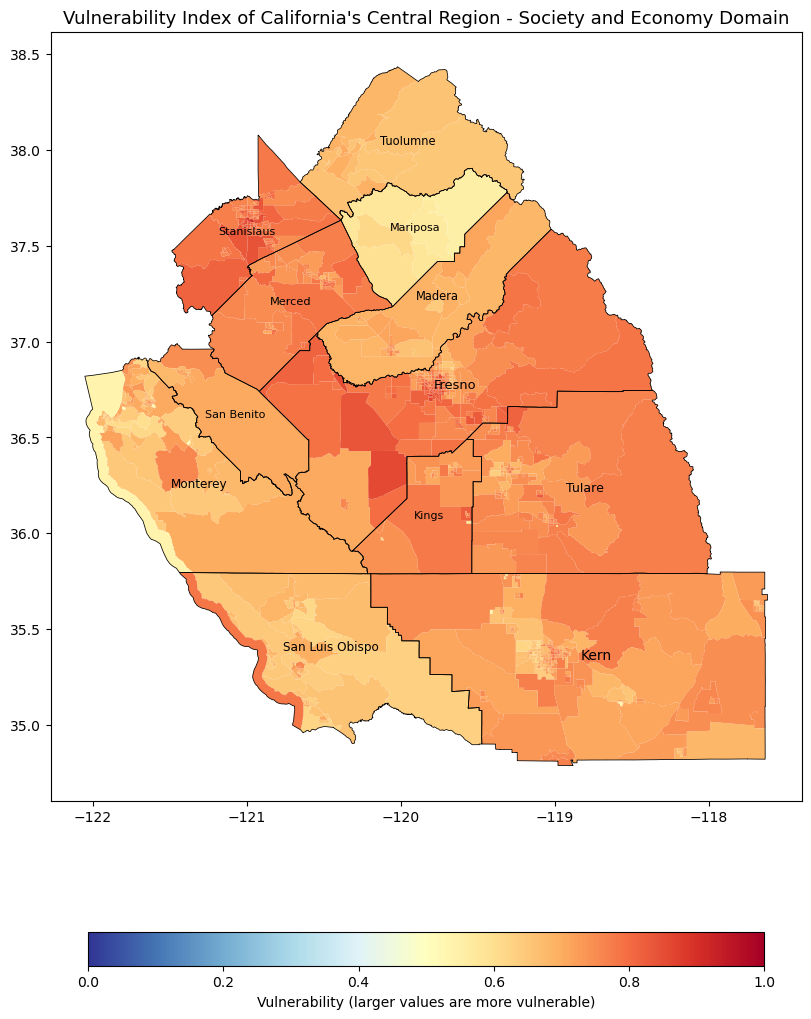

In [31]:
plot_region_domain(min_max_standardized_society_economy_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Society and Economy Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


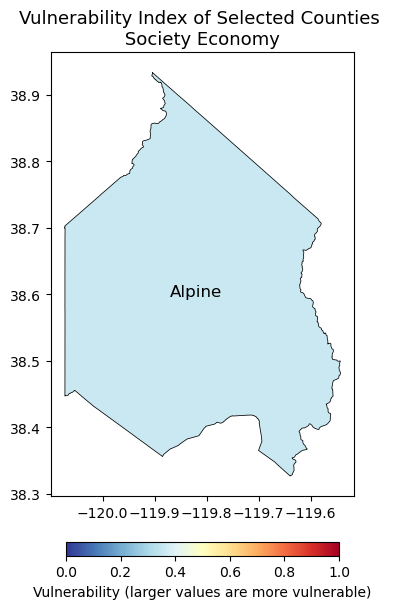

In [32]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_society_economy_domain, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


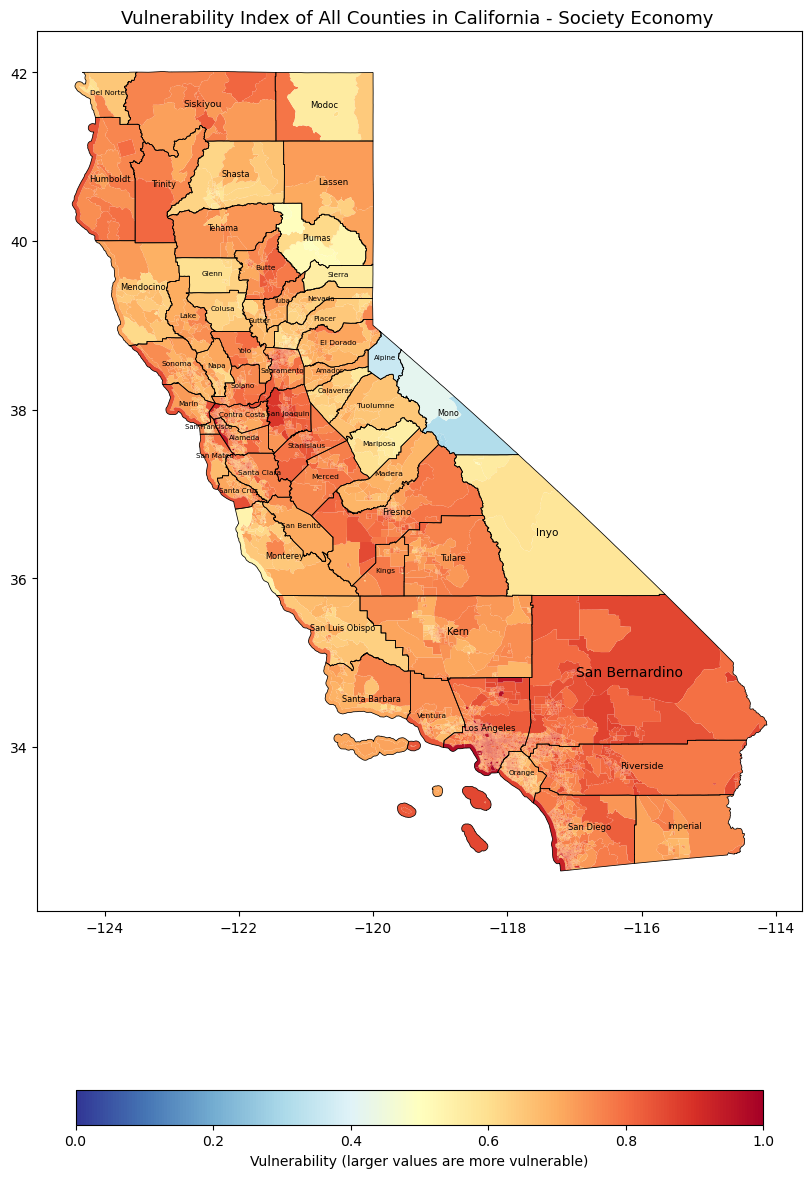

In [33]:
plot_region_domain(min_max_standardized_society_economy_domain, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [17]:
# set-up file for export
filename = '{}index_data.csv'.format(domain_prefix)
gdf.to_csv(filename, index=False)

# export to AWS (Cal-CRAI)
directory = '3_fair_data/domain_standardized_data'
upload_csv_aws([filename], bucket_name, directory)